# Model Prediksi Seri Waktu: Mengetahui Jumlah Pesanan Perusahaan Taksi

Perusahaan taksi `Sweet Lift` ingin memprediksi jumlah pesanan taksi untuk satu jam ke depan dengan batasan metrik RMSE tidak lebih dari 48 pada test set. Data historis dari Maret hingga Agustus 2018 akan digunakan. 

Langkah-langkah proyek ini melibatkan resampling data per jam, analisis time series untuk mendapatkan insights, pelatihan model machine learning dengan variasi hiperparameter, pengujian dengan metrik RMSE pada test set, dan akhirnya membuat prediksi untuk September 2018 menggunakan model terbaik.

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [Tahap 1. Persiapan](#cont_1)
* [Tahap 2. Analisis](#cont_2)
* [Tahap 3. Pelatihan](#cont_3)
    * [3.1 Model Regresi Linier](#cont_4) 
    * [3.2 Model ARIMA (Autoregressive Integrated Moving Average)](#cont_5) 
    * [3.3 Model Random Forest](#cont_6) 
    * [3.4 Model LightGBM](#cont_7) 
    * [3.5 Model XGBoost](#cont_8) 
    * [3.6 Model Hybrid (Linear Regression + XGBoost)](#cont_9) 
* [Tahap 4. Pengujian](#cont_10)
    * [4.1 Model Regresi Linier](#cont_11) 
    * [4.2 Model ARIMA (Autoregressive Integrated Moving Average)](#cont_12) 
    * [4.3 Model Random Forest](#cont_13) 
    * [4.4 Model LightGBM](#cont_14) 
    * [4.5 Model XGBoost](#cont_15) 
    * [4.6 Model Hybrid (Linear Regression + XGBoost)](#cont_16) 
* [Tahap 5. Forecasting Menggunakan Best Model](#cont_17)
* [Tahap 6. Kesimpulan](#cont_18)

## Persiapan

Kita siapkan beberapa modul untuk mengerjakan projek ini diantaranya `pandas`, `numpy`, `time`, `matplotlib`, `seaborn`, `scikit-learn`, `statsmodels`, `XGBoost` dan `LightGBM`. Dataset tersimpan pada file `taxi.csv`.

In [1]:
# memuat modul
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import lightgbm as lgb

# set tema untuk seaborn
sns.set_theme(palette='bright')

In [2]:
# memuat dataset
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
# menampilkan dataset
print(df.info())

# menampilkan sampel dataset
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-06-27 05:30:00,9
2018-03-15 02:10:00,8
2018-08-20 18:50:00,31
2018-05-16 18:20:00,12
2018-04-15 00:00:00,13


Dataset berisi informasi berikut:

Indeks
- `datetime` merupakan seri waktu

Kolom
- `num_orders` merupakan jumlah pesanan

Dari data yang ada, kita lihat terdapat `26496 baris` dan satu kolom `num_orders`. Kita tidak memiliki `nilai yang hilang` pada dataset ini. Tanggal direcord dari `1 Maret 2018` hingga `31 Agustus 2018`.

In [4]:
# mengecek duplikasi data
df.reset_index().duplicated().sum()

0

Kita juga tidak memiliki `duplikat` pada dataset. Selanjutnya kita akan melakukan `resampling` dataset agar menjadi `1 jam` perubahan.

In [5]:
# melakukan resampling data agar menjadi tiap jam
df = df.resample('1H').sum()

## Analisis

Selanjutnya kita akan melakukan eksplorasi dataset `time series` menggunakan teknik `dekomposisi time series`, dimana kita akan mengekstraksi data menjadi data `trend`, `seasonal` dan `residu` untuk menemukan pola.

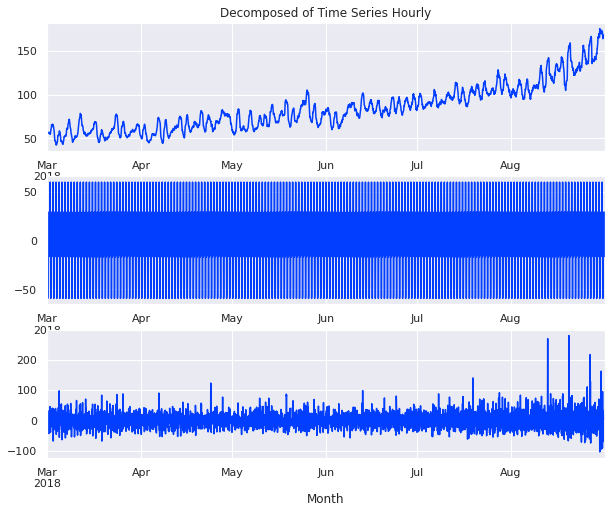

In [6]:
# membuat dekomposisi time series
decomposed = seasonal_decompose(df['num_orders'])

# visualisasi garis trend pada time series
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('Decomposed of Time Series Hourly')
decomposed.trend.plot(ax=plt.gca())

# visualisasi seasonal pada time series
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

# visualisasi residu pada time series
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Month')
plt.show()

Bisa kita lihat untuk data `trend` memiliki kecenderungan meningkat sepanjang bulan dari bulan `maret` hingga `agustus`. Namun untuk data `seasonal` tidak begitu jelas, mari kita filter dataset untuk lebih mudah memahami `seasonal`. Kita ambil sampel data dari tanggal `1 mei 2018` hingga `15 mei 2018`.

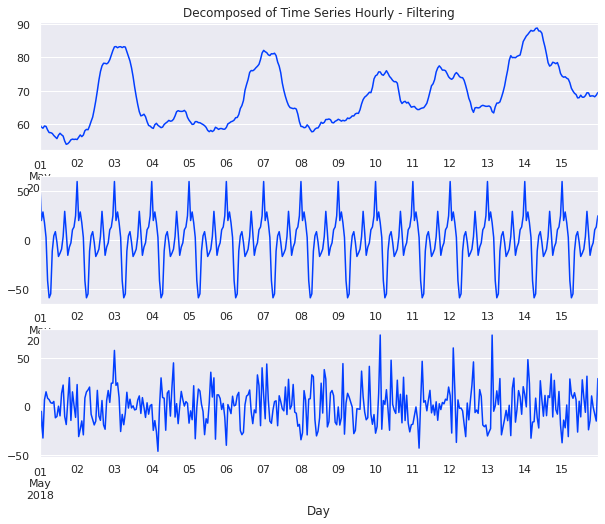

In [7]:
# memfilter decomposed time series dari tanggal 1 mei 2018 hingga 15 mei 2018
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('Decomposed of Time Series Hourly - Filtering')
decomposed.trend['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.xlabel('Day')
plt.show()

Kebalikanya, kita bisa melihat data `seasonal` lebih jelas, namun untuk data `trend` tidak begitu jelas. Nampaknya kita menemukan polanya menunjukan pola `seasonal` harian. Mari kita perjelas lagi dengan mem-`filter` dataset agar menjadi harian agar bisa terlihat perubahan perjamnya, kita ambil tanggal `1 Mei 2018`.

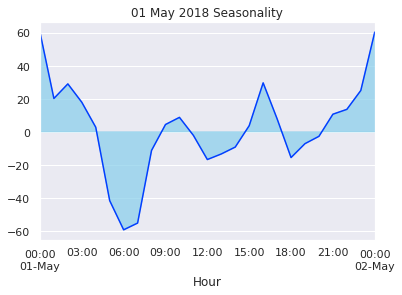

In [8]:
# memfilter seasonal pada tanggal 1 dari jam 00.00 hingga 24.00
fil_seasonal = decomposed.seasonal['2018-05-01':'2018-05-15']
fil_seasonal.head(25).plot()
plt.fill_between(fil_seasonal.index, fil_seasonal.values, color='skyblue', alpha=0.7)
plt.title('01 May 2018 Seasonality')
plt.xlabel('Hour')
plt.show()

Terlihat bahwa jam-jam sibuk terjadi pada jam `00.00` atau `24.00` dimana puncak order tertinggi dan jam longgar pada jam `06.00` dimana puncak orderan terendah. Selanjutnya kita akan melakukan visualisasi jumlah orderan terhadap `tanggal` dan `dayofweek` seperti berikut. 

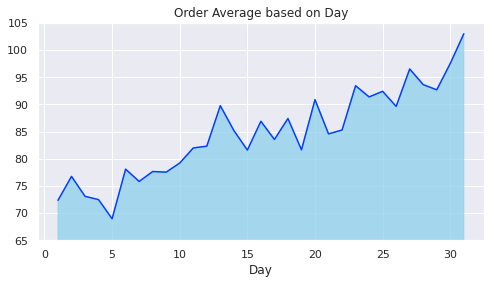

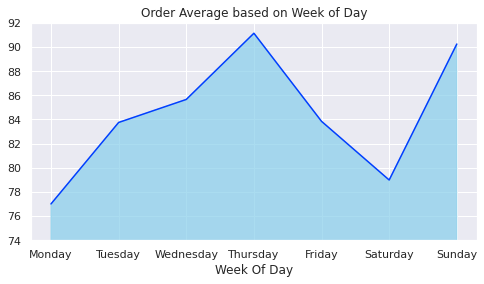

In [9]:
# duplikasi dataset sementara
temp = df.copy()
temp['day'] = temp.index.day                # menambahkan kolom day
temp['dayofweek'] = temp.index.dayofweek    # menambahkan kolom dayofweek

# melakukan plot grafik jumlah oder berdasarkan tanggal
day = temp.groupby('day')['num_orders'].mean()
plt.figure(figsize=(8,4))
day.plot(kind='line')
plt.fill_between(day.index, day.values, color='skyblue', alpha=0.7)
plt.xticks(rotation=0)
plt.title('Order Average based on Day')
plt.ylim(65,105)
plt.xlabel('Day')
plt.show()

# melakukan plot grafik jumlah oder berdasarkan dayofweek
day_list = {
    0:'Sunday',
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday'
}
temp['DayName'] = temp['dayofweek'].map(day_list)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week = temp.groupby('DayName')['num_orders'].mean()
day_of_week = day_of_week.reindex(day_order)
plt.figure(figsize=(8,4))
day_of_week.plot(kind='line')
plt.fill_between(day_of_week.index, day_of_week.values, color='skyblue', alpha=0.7)
plt.xticks(rotation=0)
plt.title('Order Average based on Week of Day')
plt.xlabel('Week Of Day')
plt.ylim(74,92)
plt.show()

Pada grafik pertama, `jumlah orderan rata-rata` terhadap `tanggal` semakin meningkat hingga puncak-puncaknya di akhir bulan. Sedangkan pada grafik kedua, `jumlah orderan rata-rata` terhadap `dayofweek` menunjukan bahwa dihari `senin` dan `sabtu` jumlah rata-rata orderan paling `rendah` dan sebaliknya dihari `kamis` dan `minggu` jumlah rata-rata orderan paling `tinggi`.

Berdasarkan perihal diatas kita akan membuat fungsi untuk menciptakan `fitur-fitur time series` berdasarkan `tanggal` sebagai `input`-nya. Kita sementara tidak akan membuat fitur lain seperti `lag`, `difference` dan `moving average`, jika hasil menunjukan kurang bagus kita akan membuat fitur-fitur tersebut.

In [10]:
# membuat fitur untuk dataset
def make_features(data):
    # menduplikasi dataset
    new_df = data.copy()

    # menambahkan kolom jam, tanggal dan bulan sebagai fitur
    new_df['hour'] = new_df.index.hour
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['month'] = new_df.index.month

    # membuat kolom peak hour
    # jika puncak order tertinggi pada jam 00.00 maka 'high peak'
    # jika puncak order terendah pada jam 06.00 maka 'low peak' 
    # selainya 'normal'
    new_df['peak_hour'] = new_df['hour'].apply(lambda x: 'high peak' if x == 0 else 'low peak' if x == 6 else 'normal')

    # membuat kolom peak day of week
    # jika orderan tinggi pada hari kamis [4] atau minggu [0] maka 'high peak'  
    # jika orderan rendah pada hari senin [1] atau sabtu  [6] maka 'low peak'
    # selainya benilai 1
    new_df['peak_dow'] = new_df['dayofweek'].apply(lambda x: 'high peak' if (x == 4) | (x == 0) else 'low peak' if (x == 1) | (x == 6) else 'normal')

    # mendefinisikan akhir bulan
    # jika akhir bulan sekitar tanggal 25 keatas maka `end month`
    # selainya `regular`
    new_df['peak_day'] = new_df['day'].apply(lambda x: 'end month' if x >= 25 else 'regular')

    # mengembalikan dataset terbaru
    return new_df

In [11]:
# membuat fitur untuk dataset
new_df = make_features(df)

# menampilkan sampel dataset baru
new_df.sample(5)

,num_orders,hour,day,dayofweek,month,peak_hour,peak_dow,peak_day
datetime,,,,,,,,
2018-05-27 11:00:00,42,11,27,6,5,normal,low peak,end month
2018-08-19 20:00:00,116,20,19,6,8,normal,low peak,regular
2018-08-18 06:00:00,55,6,18,5,8,low peak,normal,regular
2018-06-22 15:00:00,75,15,22,4,6,normal,high peak,regular
2018-08-08 07:00:00,27,7,8,2,8,normal,normal,regular


Nampaknya fungsi untuk menciptakan `fitur time series` berdasarkan `tanggal` sudah berjalan dengan baik. 

## Pelatihan

Pada bagian ini kita akan menguji beberapa `model machine learning` untuk memprediksi `time series`, dimana kebanyakan hanya menggunakan `default` dari `hyperparameter` bawaan model. Model-model tersebut diantaranya `Regresi Linier`, `ARIMA`, `Random Forest`, `LightGBM`, `XGBoost` dan `Hybrid`.

### Model Regresi Linier <a id='cont_4'></a>

Kita akan menggunakan `regresi linier` dari modul `scikit-learn` untuk memprediksi `time series`. Dataset `test` akan dibagi menjadi `90% train` dan `10% test` tanpa pengacakan, kemudian kita hitung skor `RMSE` menggunakan dataset `test`. Kita juga perlu untuk mengubah dataset `kategorik` menjadi numerik menggunakan `pandas getdummies/one hot encoder`.

In [12]:
# membagi dataset untuk fitur dan target
X = new_df.drop('num_orders',axis=1)
y = new_df['num_orders']

# mengubah kolom kategorik menjadi numerik
X_dum = pd.get_dummies(X,drop_first=True)

# membagi dataset 10% untuk test
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.1, shuffle=False)

In [13]:
# membuat model linier regresi
linreg_model = LinearRegression()

# melakukan fit, predict dan hitung skor
linreg_model.fit(X_train,y_train)
linreg_pred = linreg_model.predict(X_test)
linreg_RMSE = np.round(mean_squared_error(y_test,linreg_pred,squared=False),2)
print('RMSE Regresi Linier:', linreg_RMSE)

RMSE Regresi Linier: 59.06


### Model ARIMA (Autoregressive Integrated Moving Average) <a id='cont_5'></a>

Model ini merupakan model yang berasal dari `statsmodels` dimana menggunakan `p,d,q` sebagai parameter `Autoregresive, Integrated dan Moving Average`. Dataset akan dipisah menjadi `90% train` dan `10% test` tanpa pengacakan, sedangkan parameter `p,d,q` kita kan peroleh dari kurva `ACF` dan `PACF` berikut.

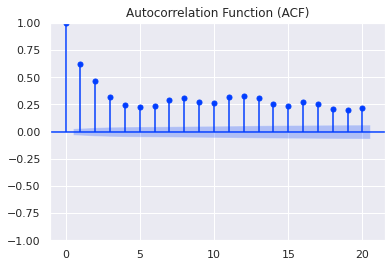

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


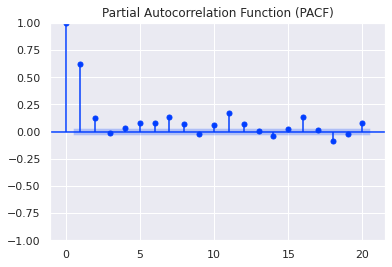

In [14]:
# membuat ACF plot
plot_acf(df['num_orders'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# membuat PACF plot
plot_pacf(df['num_orders'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Jika kita menentukan `treshold` sebesar `0.5`, maka pada grafik `ACF` kita akan menjadikan `q=2` dan dari grafik `PACF` kita akan menjadikan `p=1`. Selain itu kita akan menggunakan `Integration` dimana `d=1`. Maka parameter `ARIMA` akan menjadi seperti berikut.

In [15]:
# membuat dataset khusus arima
df_arima = df.copy()

# membagi dataset 10% untuk test
train, test = train_test_split(df_arima, test_size=0.1, shuffle=False)

# membuat model arima dengan p=1, d=1, q=2
arima_model = ARIMA(train, order = (1,1,2)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3974
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -19261.181
Date:                Sat, 27 Jan 2024   AIC                          38530.363
Time:                        09:55:31   BIC                          38555.512
Sample:                    03-01-2018   HQIC                         38539.281
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4921      0.030     16.494      0.000       0.434       0.551
ma.L1         -1.0490      0.034    -31.267      0.000      -1.115      -0.983
ma.L2          0.0546      0.033      1.667      0.0

In [16]:
# menghitung skor RMSE untuk model arima
forecast_length = len(test)
arima_pred = arima_model.get_forecast(forecast_length).predicted_mean
arima_RMSE_ori = np.round(mean_squared_error(y_test,arima_pred,squared=False),2)
print('RMSE ARIMA:', arima_RMSE_ori)

RMSE ARIMA: 64.4


### Model Random Forest <a id='cont_6'></a>

Sama seperti model `regresi linier` untuk dataset yang digunakan untuk melatih dan menghitung skor `RMSE`. `Random forest` yang kita gunakan berasal dari `scikit-learn` dengan `hyperparameter` bawaan yaitu `default`.

In [17]:
# membuat model random forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)

# memprediksi data test
rf_pred = rf_model.predict(X_test)

# menghitung skor RMSE untuk model random forest
rf_RMSE = np.round(mean_squared_error(y_test,rf_pred,squared=False),2)
print('RMSE RF:', rf_RMSE)

RMSE RF: 44.03


### Model LightGBM <a id='cont_7'></a>

Disini kita akan menggunakan model `LightGBM` dimana kita `tidak perlu` mengubah data `kategorik` menjadi `numerik`, cukup dengan mendefinisikan kolom-kolom mana sebagai data `kategorik`. Kita juga akan membagi data menjadi `90% train` dan `10% test` tanpa pengacakan.

In [18]:
# nama-nama kolom kategorik
category = X.select_dtypes(include=['object']).columns

# merubah tipe object menjadi category
X_lgb = X.copy()
for cat in category:
    X_lgb[cat] = X_lgb[cat].astype('category')

# membagi dataset untuk lgbm
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb, y, test_size=0.1, random_state=75)

# transformasi dataset ke lgbm dataset
train_data = lgb.Dataset(data=X_train_lgb, label=y_train_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
test_data = lgb.Dataset(data=X_test_lgb, label=y_test_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))

# mendefinisikan parameter lgbm
param_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.02,
    'verbose': -1
}

# melatih model lgbm
lgbm_model = lgb.train(
    params=param_lgb,
    train_set=train_data,
    num_boost_round=200
)

# memprediksi data test
lgb_pred = lgbm_model.predict(X_test_lgb)

# menghitung skor RMSE untuk model ligthGBM
lgb_RMSE = np.round(mean_squared_error(y_test_lgb,lgb_pred,squared=False),2)
print('RMSE LightGBM:', lgb_RMSE)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


RMSE LightGBM: 21.0


### Model XGBoost <a id='cont_8'></a>

Model ini berasal dari `XGBoost DMLC` yang merupakan model populer yang digunakan untuk kalangan data scientist. Disini kita akan menggunakan `hyperparameter` bawaan yaitu `default`. Kita juga menggunakan data yang sudah dibagi menjadi `90% train` dan `10% test` tanpa pengacakan.

In [19]:
# membuat model xgboost
xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)

# memprediksi data test
xgb_pred = xgb_model.predict(X_test)

# menghitung skor RMSE untuk model xgboost
xgb_RMSE = np.round(mean_squared_error(y_test,xgb_pred,squared=False),2)
print('RMSE XGBoost:', xgb_RMSE)

RMSE XGBoost: 48.33


### Model Hybrid (Linear Regression + XGBoost) <a id='cont_9'></a>

Model ini cukup berbeda dengan model-model sebelumnya dimana kita menggunakan `2 model` secara bersama-sama untuk memprediksi `time series`. Disini kita menggunakan `model regresi linier` dan `model xgboost` didalamnya secara berurutan. Model `regresi linier` digunakan untuk mencari `trend` kemudian dilakukan perhitungan residu antara `hasil true` dan `hasil predict`. Kemudian residu tersebut akan dipelajari sebagai `target` menggunakan model `xgboost`. Hasil akhir merupakan gabungan antara hasil dari model `regresi linier` dan hasil dari model `xgboost`. 

In [20]:
# menghitung residu dari hasil prediksi training regresi linier
resid = y_train - linreg_model.predict(X_train)

# melatih model xgboost dengan data residu
xgb_model.fit(X_train,resid)

# memprediksi data test
linreg_pred = linreg_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
final_pred = linreg_pred + xgb_pred

# menghitung skor RMSE untuk model hibrid
hybrid_RMSE = np.round(mean_squared_error(y_test,final_pred,squared=False),2)
print('RMSE Hybrid:', hybrid_RMSE)

RMSE Hybrid: 45.92


## Pengujian <a id='cont_10'></a>

Setelah dilakukan beberapa pelatihan, nampaknya sudah ada beberapa model yang menunjukan `skor RMSE` dibawah `48` yang sudah memenuhi kriteria. Namun kita akan mencoba melakukan `tuning` pada `hyperparameter` dari model untuk mendapatkan `skor RMSE` serendah mungkin. Pada proses `tuning` kita akan menggunakan `GridSearchCV` dari modul `sckikit-learn`, namun ada beberapa model yang secara manual untuk dilakukan `tuning`.

### Model Regresi Linier <a id='cont_11'></a>

In [21]:
# membuat skor RMSE
def RMSE(true,pred):
    mse = mean_squared_error(true,pred)
    return np.sqrt(mse)

RMSE_score = make_scorer(RMSE)

# melihat parameter model regresi linier
linreg_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

Dari `output` diatas menunjukan beberapa parameter yang bisa dilakukan `tuning`, kita akan mengambil `fit_intercept` dan `positive` untuk kita cari yang terbaik.

In [22]:
# mendefinisikan jumlah cross validation
cv_tmsrs = TimeSeriesSplit(n_splits=5)

# mendefinisikan parameter regresi linier
linreg_params = {
    'fit_intercept':[True,False],
    'positive':[True,False]
}

# membuat gridsearchCV untuk regresi linier menggunakan data full
time_start = time.time()
grid_linreg = GridSearchCV(linreg_model,param_grid=linreg_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_linreg.fit(X_dum,y)
time_end = time.time()
lr_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_lr = grid_linreg.best_estimator_
linreg_pred_train = best_model_lr.predict(X_train)
linreg_RMSE_train = np.round(mean_squared_error(y_train,linreg_pred_train,squared=False),2)
linreg_pred_test = best_model_lr.predict(X_test)
linreg_RMSE_test = np.round(mean_squared_error(y_test,linreg_pred_test,squared=False),2)

print('Best Params', grid_linreg.best_params_)
print('RMSE Best-Linreg - Train:', linreg_RMSE_train)
print('RMSE Best-Linreg - Test:', linreg_RMSE_test)

Best Params {'fit_intercept': True, 'positive': True}
RMSE Best-Linreg - Train: 34.72
RMSE Best-Linreg - Test: 60.05


### Model ARIMA (Autoregressive Integrated Moving Average) <a id='cont_12'></a>

Pada model `ARIMA` kita akan melakukan `tuning` secara `manual` dimana `hyperparameter` yang kita optimalkan adalah `order` seperti berikut.

In [23]:
# order = [(0,1,2),(2,1,0),(0,1,0),(2,1,2),(2,2,2)]
p = [0,2,0,2,2]
d = [1,1,1,1,2]
q = [2,0,0,2,2]

time_start = time.time()
param_arima = []
rmse_arima = []
for a,b,c in zip(p,d,q):
    # membuat model arima dengan order x,y,z
    arima_model = ARIMA(train, order = (a,b,c)).fit()

    # menghitung skor RMSE untuk model arima
    forecast_length = len(test)
    arima_pred = arima_model.get_forecast(forecast_length).predicted_mean
    arima_RMSE = np.round(mean_squared_error(y_test,arima_pred,squared=False),2)
    param_arima.append(zip([a,b,c]))
    rmse_arima.append(arima_RMSE)
time_end = time.time()
arima_grid_time = np.round(time_end - time_start,3)

best_rmse_arima = np.min(rmse_arima)
best_param_arima = param_arima[np.argmin(rmse_arima)]

print('Best Order', list(best_param_arima))
print('Best RMSE', best_rmse_arima)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best Order [(0,), (1,), (0,)]
Best RMSE 62.05


### Model Random Forest <a id='cont_13'></a>

In [24]:
# melihat parameter model random forest
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Dari `output` diatas menunjukan beberapa parameter yang bisa dilakukan `tuning`, kita akan mengambil `n_estimators`, `max_depth` dan `min_samples_split` untuk kita cari yang terbaik.

In [25]:
# mendefinisikan parameter random forest
rf_params = {
    'n_estimators':[50,100,200,250],
    'random_state':[42],
    'max_depth':[5,10,15],
    'min_samples_split':[3,5,10]
}

# membuat gridsearchCV untuk random forest menggunakan data full
time_start = time.time()
grid_rf = GridSearchCV(rf_model,param_grid=rf_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_rf.fit(X_dum,y)
time_end = time.time()
rf_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_rf = grid_rf.best_estimator_
rf_pred_train = best_model_rf.predict(X_train)
rf_RMSE_train = np.round(mean_squared_error(y_train,rf_pred_train,squared=False),2)
rf_pred_test = best_model_rf.predict(X_test)
rf_RMSE_test = np.round(mean_squared_error(y_test,rf_pred_test,squared=False),2)

print('Best Params', grid_rf.best_params_)
print('RMSE Best-RF - Train:', rf_RMSE_train)
print('RMSE Best-RF - Test:', rf_RMSE_test)

Best Params {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 250, 'random_state': 42}
RMSE Best-RF - Train: 25.67
RMSE Best-RF - Test: 38.69


### Model LightGBM <a id='cont_14'></a>

In [26]:
# melihat parameter model ligthGBM
lgbm_model.params

{'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'num_leaves': 31,
 'learning_rate': 0.02,
 'verbose': -1,
 'num_iterations': 200,
 'early_stopping_round': None,
 'categorical_column': [4, 5, 6]}

Sama seperti model `ARIMA` kita akan melakukan `tuning` secara `manual`. Adapun `hyperparameter` yang akan kita `tuning` yaitu `learning_rate` dan `num_iterations`.

In [27]:
# mendefinisikan parameter lightGBM
learning = [0.001,0.01,0.1,0.2,0.5]
num_iter = [50,100,200,250,500,1000]

# optimasi number boosting atau number iterator
time_start = time.time()
best_iter = 1000
rmse_iter = 1000
for iter in num_iter:
    full_data = lgb.Dataset(data=X_lgb, label=y, feature_name=list(X_lgb.columns), categorical_feature=list(category))
    train_data = lgb.Dataset(data=X_train_lgb, label=y_train_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
    test_data = lgb.Dataset(data=X_test_lgb, label=y_test_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
    param_lgb = {'objective': 'regression','metric': 'rmse','boosting_type': 'gbdt','num_leaves': 31,'learning_rate': 0.02,'verbose': -1}
    lgbm_model = lgb.train(params=param_lgb,train_set=train_data,num_boost_round=iter)
    # memprediksi data test
    lgb_pred = lgbm_model.predict(X_test_lgb)
    # menghitung skor RMSE untuk model lightGBM
    lgb_RMSE = np.round(mean_squared_error(y_test_lgb,lgb_pred,squared=False),2)
    if lgb_RMSE < rmse_iter:
        best_iter = iter
        rmse_iter = lgb_RMSE

# optimasi learning rate
best_lrn = 1000
rmse_lrn = 1000
for lrn in learning:
    train_data = lgb.Dataset(data=X_train_lgb, label=y_train_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
    test_data = lgb.Dataset(data=X_test_lgb, label=y_test_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
    param_lgb = {'objective': 'regression','metric': 'rmse','boosting_type': 'gbdt','num_leaves': 31,'learning_rate': lrn,'verbose': -1}
    lgbm_model = lgb.train(params=param_lgb,train_set=train_data,num_boost_round=best_iter)
    # memprediksi data test
    lgb_pred = lgbm_model.predict(X_test_lgb)
    # menghitung skor RMSE untuk model lightGBM
    lgb_RMSE = np.round(mean_squared_error(y_test_lgb,lgb_pred,squared=False),2)
    if lgb_RMSE < rmse_lrn:
        best_lrn = lrn
        rmse_lrn = lgb_RMSE
time_end = time.time()
lgb_grid_time = np.round(time_end - time_start,3)

print('Best Learning Rate:', best_lrn)
print('Best Number Boosting:',best_iter)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_fe

Best Learning Rate: 0.01
Best Number Boosting: 500


In [28]:
# transformasi dataset ke lgbm dataset
train_data = lgb.Dataset(data=X_train_lgb, label=y_train_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))
test_data = lgb.Dataset(data=X_test_lgb, label=y_test_lgb, feature_name=list(X_lgb.columns), categorical_feature=list(category))

# mendefinisikan parameter lgbm
param_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': best_lrn,
    'verbose': -1
}

lgbm_model = lgb.train(
    params=param_lgb,
    train_set=train_data,
    num_boost_round=best_iter
)

# memprediksi data train dan test
lgb_pred_train = lgbm_model.predict(X_train_lgb)
lgb_pred_test = lgbm_model.predict(X_test_lgb)

# menghitung skor RMSE untuk model lightGBM akhir
lgb_RMSE_opt_train = np.round(mean_squared_error(y_train_lgb,lgb_pred_train,squared=False),2)
lgb_RMSE_opt_test = np.round(mean_squared_error(y_test_lgb,lgb_pred_test,squared=False),2)
print('RMSE LightGBM - Train:', lgb_RMSE_opt_train)
print('RMSE LightGBM - Test:', lgb_RMSE_opt_test)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


RMSE LightGBM - Train: 20.26
RMSE LightGBM - Test: 20.63


### Model XGBoost <a id='cont_15'></a>

In [29]:
# melihat parameter model xgboost
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Dari `output` diatas menunjukan beberapa parameter yang bisa dilakukan `tuning`, kita akan mengambil `n_estimators`, `max_depth` dan `learning_rate` untuk kita cari yang terbaik.

In [30]:
# mendefinisikan parameter XGBoost
xgb_params = {
    'n_estimators':[250,500,1000],
    'random_state':[42],
    'max_depth':[5,10,15],
    'learning_rate':[0.01,0.2,0.5],
}

# membuat gridsearchCV untuk XGBoost menggunakan data full
time_start = time.time()
grid_xgb = GridSearchCV(xgb_model,param_grid=xgb_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_xgb.fit(X_dum,y)
time_end = time.time()
xgb_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_xgb = grid_xgb.best_estimator_
xgb_pred_train = best_model_xgb.predict(X_train)
xgb_RMSE_train = np.round(mean_squared_error(y_train,xgb_pred_train,squared=False),2)
xgb_pred_test = best_model_xgb.predict(X_test)
xgb_RMSE_test = np.round(mean_squared_error(y_test,xgb_pred_test,squared=False),2)

print('Best Params', grid_xgb.best_params_)
print('RMSE Best-XGB - Train:', xgb_RMSE_train)
print('RMSE Best-XGB - Test:', xgb_RMSE_test)

Best Params {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 250, 'random_state': 42}
RMSE Best-XGB - Train: 14.2
RMSE Best-XGB - Test: 24.9


### Model Hybrid (Linear Regression + XGBoost) <a id='cont_16'></a>

Pada model ini kita tidak perlu melakukan `tuning`, kita langsung menggunakan model terbaik yang sudah kita `tuning` sebelumnya untuk memprediksi data dan menghitung `skor RMSE`.

In [31]:
# menghitung residu dari hasil prediksi training regresi linier optimal
resid = y_train - best_model_lr.predict(X_train)

# melatih model xgboost dengan data residu
best_model_xgb.fit(X_train,resid)

# memprediksi data train
linreg_pred_train_h = best_model_lr.predict(X_train)
xgb_pred_train_h = best_model_xgb.predict(X_train)
final_pred_train = linreg_pred_train_h + xgb_pred_train_h

# memprediksi data test
linreg_pred_test_h = best_model_lr.predict(X_test)
xgb_pred_test_h = best_model_xgb.predict(X_test)
final_pred_test = linreg_pred_test_h + xgb_pred_test_h
hybrid_grid_time = lr_grid_time + xgb_grid_time

# menghitung skor RMSE untuk model hibrid
hybrid_RMSE_train = np.round(mean_squared_error(y_train,final_pred_train,squared=False),2)
hybrid_RMSE_test = np.round(mean_squared_error(y_test,final_pred_test,squared=False),2)
print('RMSE Best-Hybrid - Train:', hybrid_RMSE_train)
print('RMSE Best-Hybrid - Test:', hybrid_RMSE_test)

RMSE Best-Hybrid - Train: 7.96
RMSE Best-Hybrid - Test: 41.82


In [32]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'RMSE Original': [linreg_RMSE,arima_RMSE_ori,rf_RMSE,lgb_RMSE,xgb_RMSE,hybrid_RMSE],
    'RMSE-Opt Train ': [linreg_RMSE_train,'Not Available',rf_RMSE_train,lgb_RMSE_opt_train,xgb_RMSE_train,hybrid_RMSE_train],
    'RMSE-Opt Test': [linreg_RMSE_test,best_rmse_arima,rf_RMSE_test,lgb_RMSE_opt_test,xgb_RMSE_test,hybrid_RMSE_test],
    'Grid Time (Seconds)': [lr_grid_time,arima_grid_time,rf_grid_time,lgb_grid_time,xgb_grid_time,hybrid_grid_time]
}, index=['Linear Regression','ARIMA','Random Forest','LightGBM','XGBoost','Hybrid'])

# menampilkan tabel komparasi
table_comp

,RMSE Original,RMSE-Opt Train,RMSE-Opt Test,Grid Time (Seconds)
Linear Regression,59.06,34.72,60.05,0.195
ARIMA,64.40,Not Available,62.05,23.706
Random Forest,44.03,25.67,38.69,106.103
LightGBM,23.57,20.26,20.63,13.083
XGBoost,48.33,14.2,24.90,991.431
Hybrid,45.92,7.96,41.82,991.626


Disini kita bisa lihat bahwa `skor RMSE` untuk dataset `test` paling rendah (terbaik) dicapai oleh model `LightGBM` sedangkan yang paling tinggi (terburuk) adalah model `ARIMA`. Berdasarkan konsumsi waktu `GridSearchCV` paling lama dicapai model `Hybrid` dikarenakan konsumsi waktu `GridSearchCV` dari model `XGBoost` yang lama. Beberapa model yang masuk dalam kriteria `RMSE <= 48` adalah model `LightGBM`, `XGBoost`, `Random Forest` dan `Hybrid`.

Jika kita mempertimbangkan `waktu` untuk `tuning hyperparameter` dan juga `skor RMSE` maka model yang paling baik dan efisien adalah model `LightGBM`. Jika kita urutkan semua model dari yang paling baik hingga yang paling rendah kita bisa simpulkan `LightGBM` > `XGBoost` > `Random Forest` > `Hybrid` > `Regresi Linier` > `ARIMA`.

## Forecasting Menggunakan Best Model <a id='cont_17'></a>

Selanjutnya kita akan mencoba membuat visualiasi dari model terbaik untuk melihat gambaran antara data `historic` dan data `prediksi` serta kita akan membuat `forecast` untuk tanggal yang tidak ada pada dataset sebagai contoh pada tanggal `1 September 2018` hingga `7 September 2018`.

In [33]:
# Buat tanggal awal dan akhir
start_date = pd.Timestamp('2018-09-01 00:00:00')
end_date = pd.Timestamp('2018-09-7 23:00:00')

# Buat date_range dengan interval 1 jam
future = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='1H'))

# membuat fitur untuk masa depan
future_features = make_features(future)
category = future_features.select_dtypes(include=['object']).columns    # nama-nama kolom kategorik
forecast_lgb = future_features.copy()                                   # merubah tipe object menjadi category
for cat in category:
    forecast_lgb[cat] = forecast_lgb[cat].astype('category')

# menampilkan sampel fitur
forecast_lgb.head()

,hour,day,dayofweek,month,peak_hour,peak_dow,peak_day
2018-09-01 00:00:00,0,1,5,9,high peak,normal,regular
2018-09-01 01:00:00,1,1,5,9,normal,normal,regular
2018-09-01 02:00:00,2,1,5,9,normal,normal,regular
2018-09-01 03:00:00,3,1,5,9,normal,normal,regular
2018-09-01 04:00:00,4,1,5,9,normal,normal,regular


In [34]:
# memprediksi hasil menggunakan model lightGBM terbaik
forecast = lgbm_model.predict(forecast_lgb)
forecast = pd.DataFrame(forecast,index=forecast_lgb.index,columns=['num_orders']).rename(columns={'num_orders': 'future'})
forecast.head()

,future
2018-09-01 00:00:00,191.317194
2018-09-01 01:00:00,158.275841
2018-09-01 02:00:00,163.197885
2018-09-01 03:00:00,135.590295
2018-09-01 04:00:00,127.703533


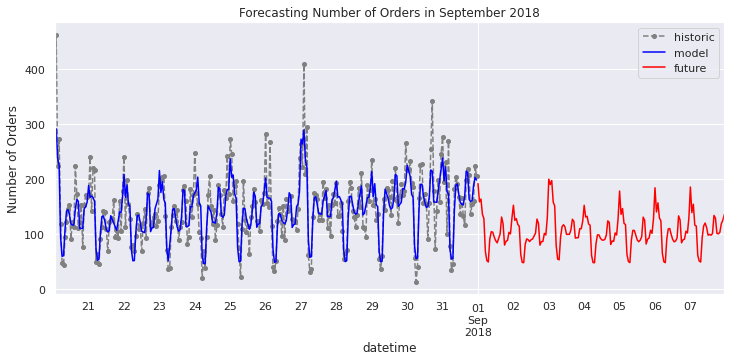

In [35]:
# mem-filter dataset
before = df[df.index > '2018-08-20'].rename(columns={'num_orders': 'historic'})
lgb_pred_train = pd.DataFrame(lgb_pred_train,index=X_train_lgb.index,columns=['model'])
model = lgb_pred_train[lgb_pred_train.index > '2018-08-20'].rename(columns={'num_orders': 'historic'}).sort_index()

# memplot grafik
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
before.plot(c='gray',linestyle='dashed', marker='o',markersize=4,figsize=(12,5),ax=axes)
model.plot(c='blue',ax=axes)
forecast.plot(c='red',ax=axes)
plt.title('Forecasting Number of Orders in September 2018')
plt.ylabel('Number of Orders')
plt.show()

Dari grafik diatas menunjukan bahwa model `LightGBM` cukup baik untuk mengikuti pola dari dataset `historic` yang ditunjukan dengan garis warna `biru` untuk bulan `Agustus 2018`. Untuk `Forecasting` digambarkan dengan garis warna `merah` untuk bulan `September 2018` hampir memiliki pola yang sama seperti bulan sebelumnya. 

# Kesimpulan <a id='cont_18'></a>


Proyek ini melibatkan pengolahan dataset `time series` dengan langkah-langkah seperti dekomposisi untuk mengidentifikasi trend, seasonal, dan residu. Selain itu, analisis pola-pola digunakan sebagai dasar untuk pembuatan fitur-fitur baru dalam time series. Pelatihan model dilakukan menggunakan berbagai metode, termasuk linear regression, ARIMA, random forest, LightGBM, XGBoost, dan model Hybrid. Proses tuning hyperparameter dilakukan secara manual dan melalui GridSearchCV untuk mencapai skor RMSE yang optimal.

Beberapa kesimpulan dari proyek ini antara lain:

Hasil dekomposisi time series menunjukkan bahwa trend data cenderung meningkat dari Maret hingga Agustus, sementara pola seasonal bersifat harian.
Jam-jam sibuk untuk pesanan tertinggi terjadi pada pukul 00.00 atau 24.00, sementara jam longgar terjadi pada pukul 06.00.
Jumlah pesanan rata-rata terhadap tanggal meningkat hingga akhir bulan, dan terhadap hari dalam seminggu menunjukkan bahwa Senin dan Sabtu memiliki jumlah pesanan rata-rata paling rendah, sedangkan Kamis dan Minggu memiliki jumlah pesanan rata-rata paling tinggi.
Model LightGBM mencapai skor RMSE terendah untuk dataset test, sedangkan model ARIMA setelah tuning hyperparameter memiliki skor RMSE tertinggi.
Urutan model dari yang terbaik hingga terburuk, berdasarkan pertimbangan skor RMSE dan waktu tuning hyperparameter, adalah LightGBM > XGBoost > Random Forest > Hybrid > Regresi Linier > ARIMA.